In [73]:
# Imports
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import shutil
import random

# ◊î◊í◊ì◊®◊ï◊™ ◊®◊†◊ì◊ï◊û◊ú◊ô◊ï◊™ ◊ú◊©◊ó◊ñ◊ï◊®
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ◊î◊í◊ì◊®◊ï◊™ ◊î◊ì◊§◊°◊î ◊ë-Jupyter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# ◊ú◊î◊¶◊ô◊í ◊í◊®◊§◊ô◊ù ◊ë◊™◊ï◊ö ◊î◊û◊ó◊ë◊®◊™
%matplotlib inline

# ◊î◊í◊ì◊®◊™ Paths
base_path = "/Users/omripeer/Documents/Omri/◊™◊ï◊ê◊® ◊®◊ê◊©◊ï◊ü ◊ë◊û◊ì◊¢◊ô ◊î◊û◊ó◊©◊ë - ◊û◊õ◊ú◊ú◊™ ◊ê◊§◊ß◊î/◊©◊†◊ô◊ù ◊ê-◊í/◊©◊†◊î ◊í/Final Project/ML Model"
images_path = os.path.join(base_path, "images")
labels_path = os.path.join(base_path, "annotations", "obj_train_data")
crops_dir = os.path.join(base_path, "crops")
os.makedirs(crops_dir, exist_ok=True)  # Create crops folder if doesn't exist


In [75]:
# Function to draw bounding boxes
import os
import cv2

# Function to draw and save bounding boxes
import os
import cv2

import os
import cv2

def plot_image_with_boxes(image, labels, image_name="annotated_image.jpg"):
    image_with_boxes = image.copy()
    height, width, _ = image.shape

    # ◊û◊ô◊§◊ï◊ô ◊û◊ñ◊î◊î ◊û◊ó◊ú◊ß◊î ◊ú◊¶◊ë◊¢
    class_colors = {
        0: (0, 0, 255),     # Resting - ◊õ◊ó◊ï◊ú
        1: (0, 255, 0),     # Surveilling - ◊ô◊®◊ï◊ß
        2: (255, 0, 0),     # Activated - ◊ê◊ì◊ï◊ù
        3: (255, 255, 0)    # Resolution - ◊¶◊î◊ï◊ë
    }

    for label in labels:
        parts = label.strip().split()
        if len(parts) != 5:
            continue
        class_id, x_center, y_center, box_width, box_height = map(float, parts)

        x_center_pixel = x_center * width
        y_center_pixel = y_center * height
        box_width_pixel = box_width * width
        box_height_pixel = box_height * height

        x_min = int(x_center_pixel - box_width_pixel / 2)
        y_min = int(y_center_pixel - box_height_pixel / 2)
        x_max = int(x_center_pixel + box_width_pixel / 2)
        y_max = int(y_center_pixel + box_height_pixel / 2)

        color = class_colors.get(int(class_id), (255, 255, 255))  # ◊ú◊ë◊ü ◊õ◊ë◊®◊ô◊®◊™ ◊û◊ó◊ì◊ú

        cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(image_with_boxes, str(int(class_id)), (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    save_name = os.path.splitext(image_name)[0] + "_annotated.jpg"
    cv2.imwrite(save_name, image_with_boxes)

    return image_with_boxes





# Function to save crops
def save_crops_from_labels(image, labels, crops_dir, starting_idx=0):
    height, width, _ = image.shape
    data = []

    for idx, label in enumerate(labels):
        parts = label.strip().split()
        if len(parts) != 5:
            continue

        class_id, x_center, y_center, box_width, box_height = map(float, parts)

        x_center_pixel = x_center * width
        y_center_pixel = y_center * height
        box_width_pixel = box_width * width
        box_height_pixel = box_height * height

        x_min = int(x_center_pixel - box_width_pixel / 2)
        y_min = int(y_center_pixel - box_height_pixel / 2)
        x_max = int(x_center_pixel + box_width_pixel / 2)
        y_max = int(y_center_pixel + box_height_pixel / 2)

        crop = image[max(0, y_min):min(height, y_max), max(0, x_min):min(width, x_max)]
        crop_filename = f"crop_{starting_idx + idx}_class_{int(class_id)}.png"
        crop_path = os.path.join(crops_dir, crop_filename)

        pil_crop = Image.fromarray(crop)
        pil_crop.save(crop_path)

        data.append({
            "crop_filename": crop_filename,
            "class_id": class_id
        })

    return data



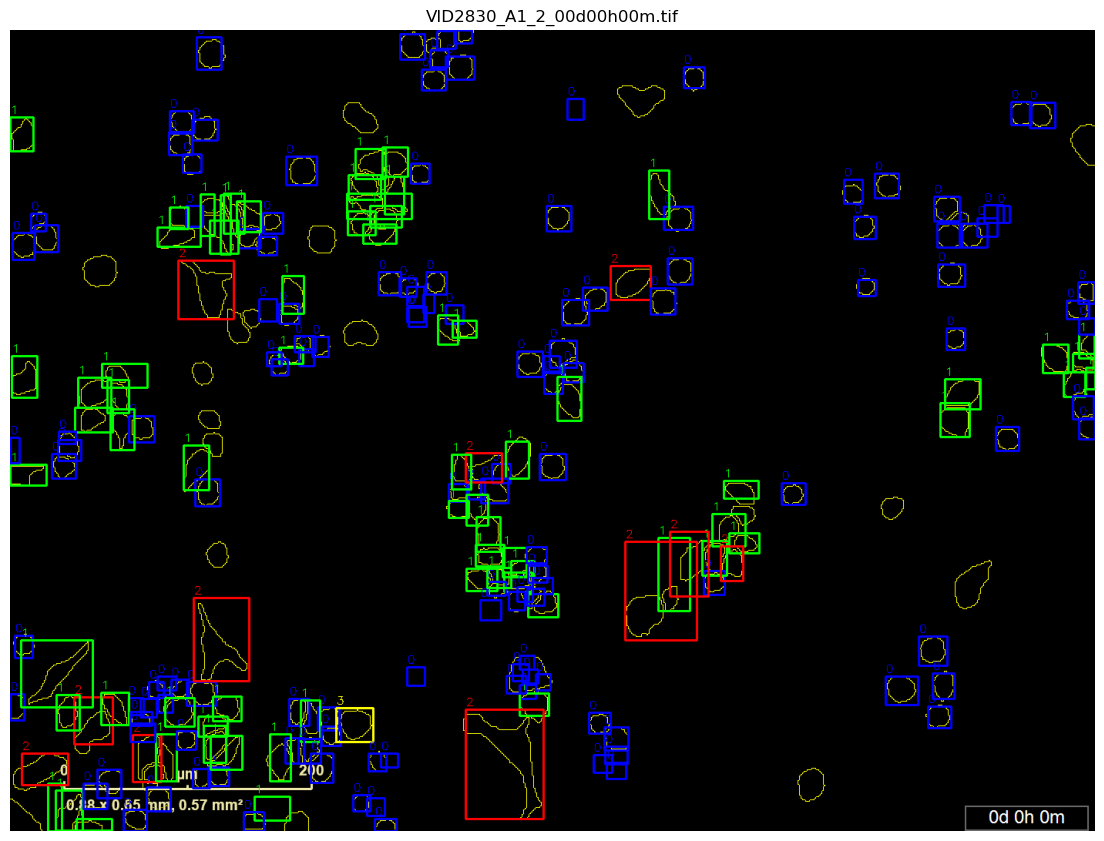

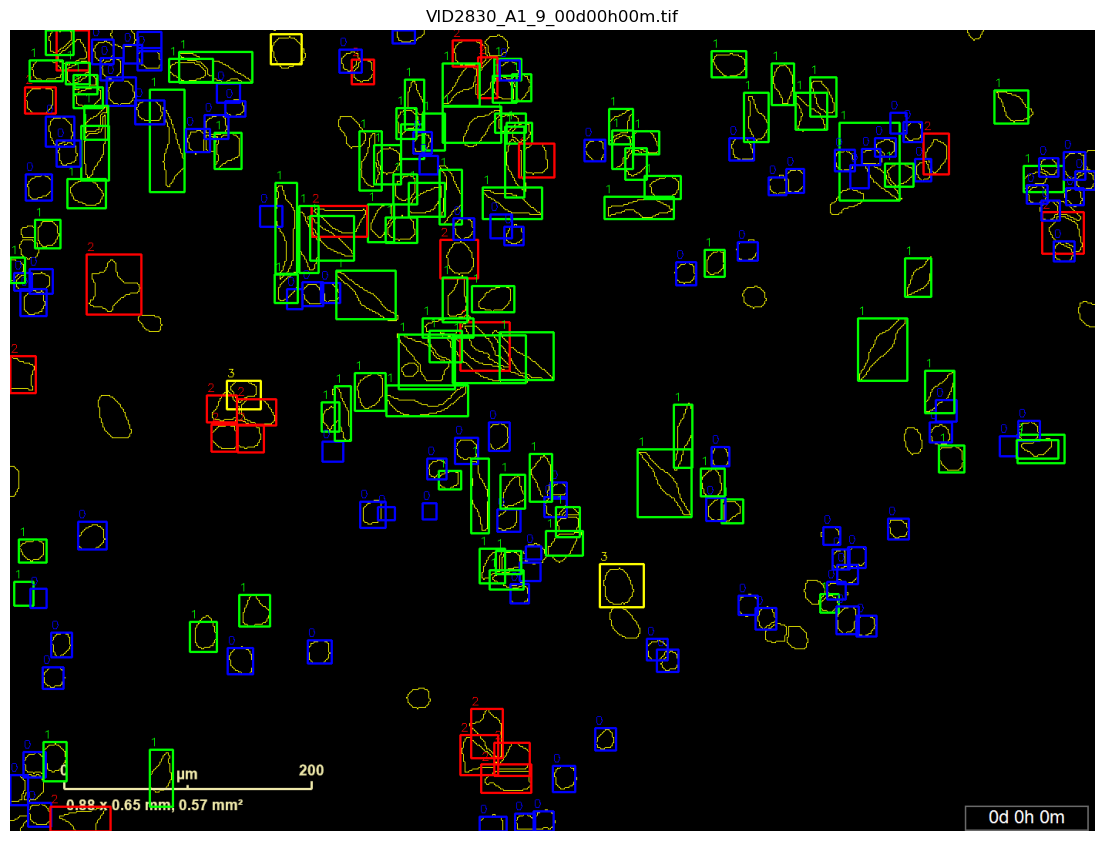

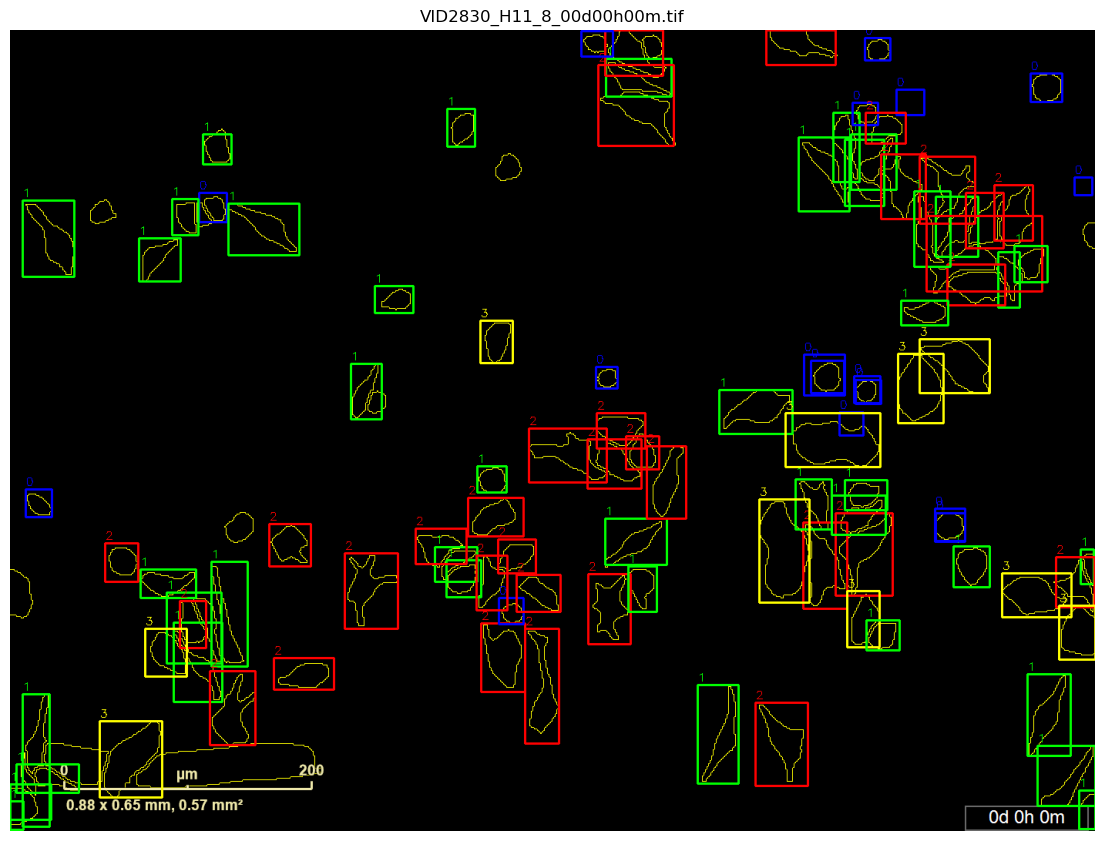

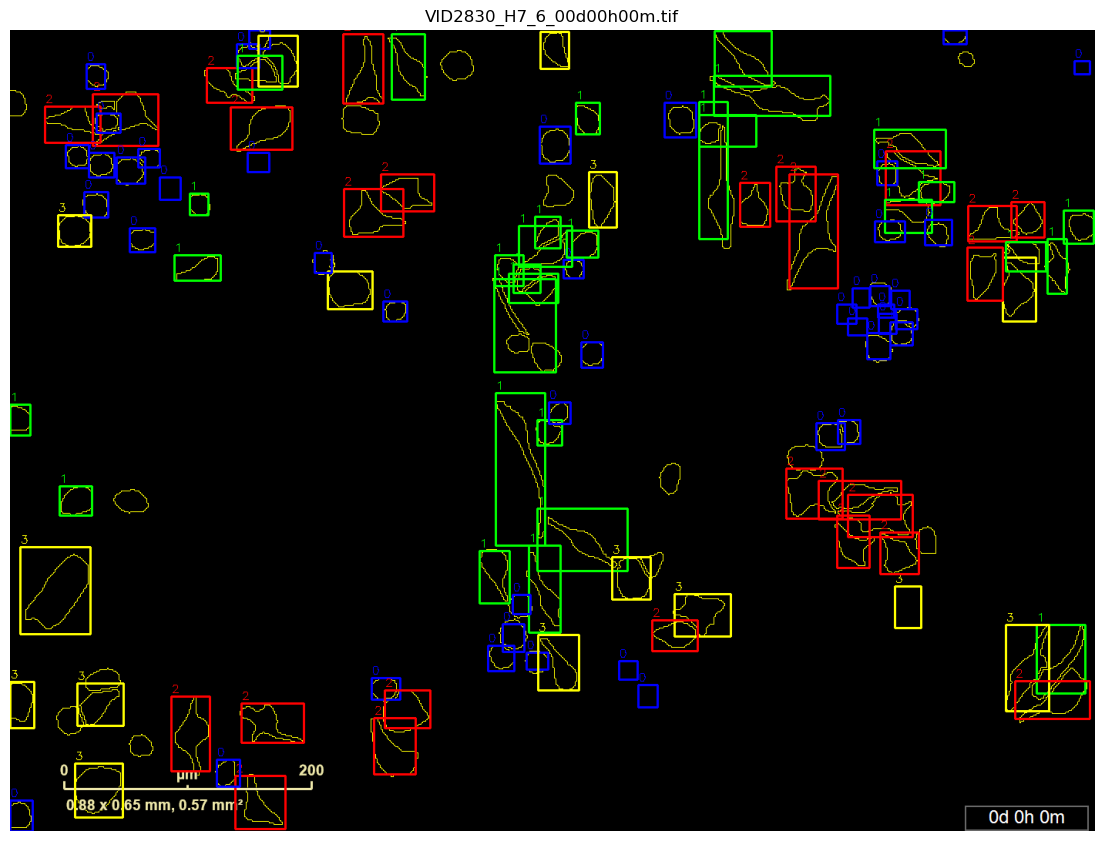

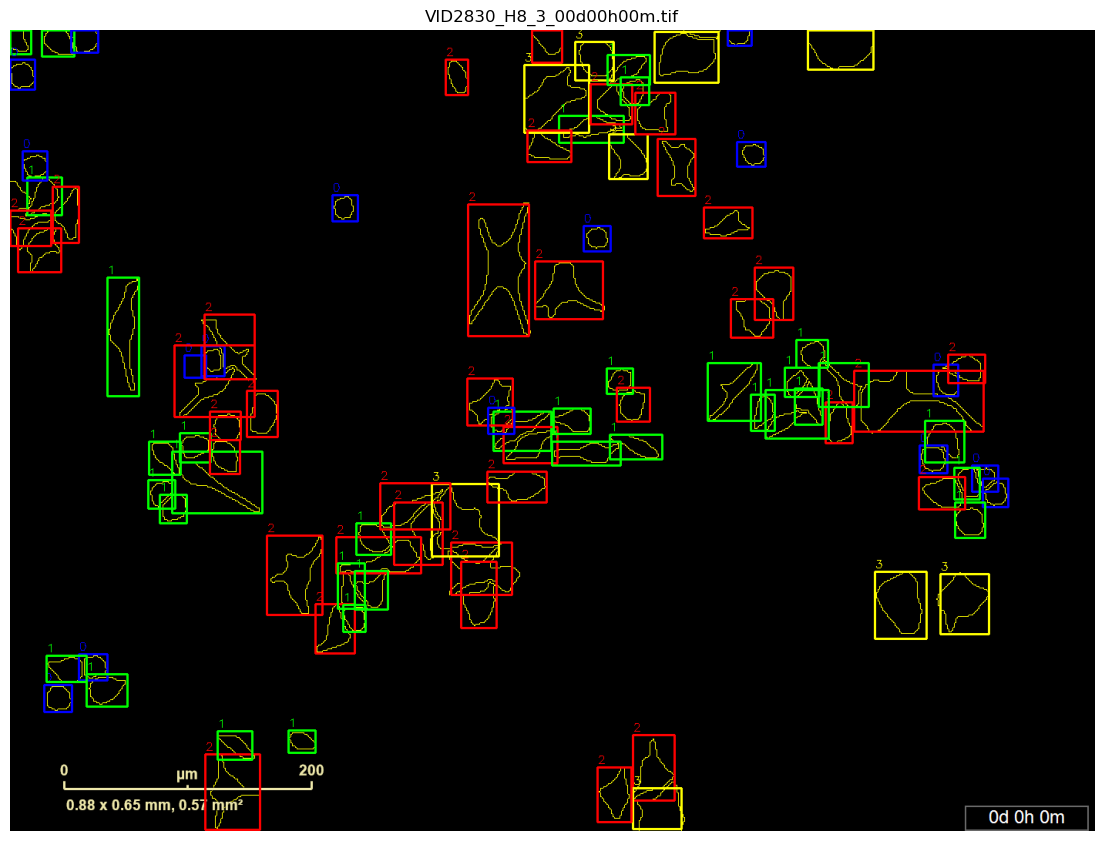

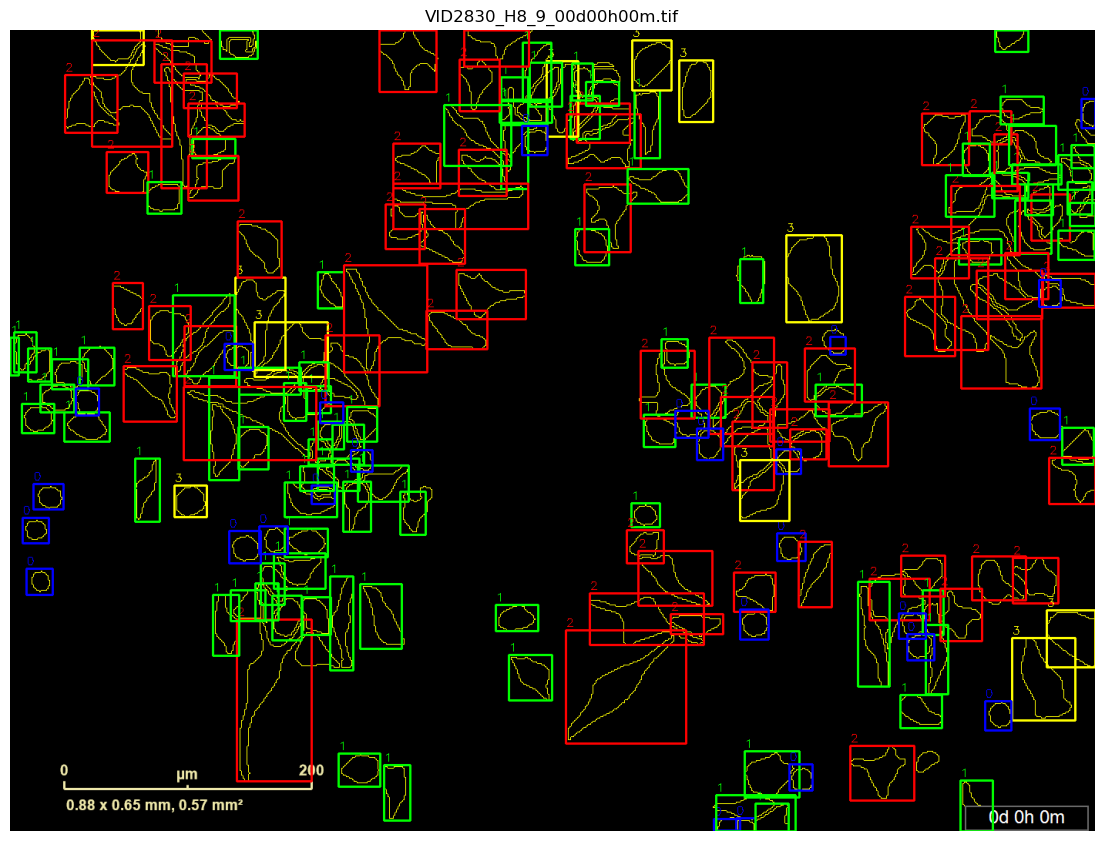

‚úÖ CSV file saved to /Users/omripeer/Documents/Omri/◊™◊ï◊ê◊® ◊®◊ê◊©◊ï◊ü ◊ë◊û◊ì◊¢◊ô ◊î◊û◊ó◊©◊ë - ◊û◊õ◊ú◊ú◊™ ◊ê◊§◊ß◊î/◊©◊†◊ô◊ù ◊ê-◊í/◊©◊†◊î ◊í/Final Project/ML Model/crops_labels.csv


In [77]:
# --- ◊ß◊®◊ô◊ê◊î ◊ï◊¢◊ô◊ë◊ï◊ì ◊î◊™◊û◊ï◊†◊ï◊™ ---
# ◊ò◊ï◊¢◊ü ◊ê◊™ ◊õ◊ú ◊î◊™◊û◊ï◊†◊ï◊™ ◊ï◊î◊ò◊ß◊°◊ò◊ô◊ù ◊û◊î◊™◊ô◊ß◊ô◊ô◊î
image_filenames = sorted([f for f in os.listdir(images_path) if f.endswith(".tif")])
label_filenames = sorted([f for f in os.listdir(labels_path) if f.endswith(".txt")])

# ◊î◊™◊ê◊û◊î ◊ú◊§◊ô ◊©◊ù ◊î◊ß◊ï◊ë◊• ◊ë◊ú◊ô ◊°◊ô◊ï◊û◊™
image_to_label = {
    os.path.splitext(img)[0]: os.path.splitext(lbl)[0]
    for img in image_filenames
    for lbl in label_filenames
    if os.path.splitext(img)[0] == os.path.splitext(lbl)[0]
}

images_and_labels = [(f"{name}.tif", f"{name}.txt") for name in image_to_label]


all_data = []
global_idx = 0

for image_filename, label_filename in images_and_labels:
    image_path = os.path.join(images_path, image_filename)
    pil_image = Image.open(image_path)
    image = np.array(pil_image)

    label_path = os.path.join(labels_path, label_filename)
    with open(label_path, "r") as file:
        labels = file.readlines()

    # ◊ú◊î◊¶◊ô◊í ◊™◊û◊ï◊†◊î ◊¢◊ù ◊™◊ô◊ë◊ï◊™
    dpi = 100
    height, width, _ = image.shape
    figsize = (width / dpi, height / dpi)

    image_with_boxes = plot_image_with_boxes(image, labels, image_name=image_filename)
    fig, ax = plt.subplots(figsize=figsize)
    _ = ax.imshow(image_with_boxes)
    _ = ax.axis("off")
    _ = ax.set_title(image_filename)
    plt.show()
    plt.close(fig)

    # ◊©◊û◊ô◊®◊™ Crops
    data = save_crops_from_labels(image, labels, crops_dir, starting_idx=global_idx)
    all_data.extend(data)
    global_idx += len(data)

# ◊ô◊¶◊ô◊®◊™ DataFrame
df = pd.DataFrame(all_data)
df["class_id"] = df["class_id"].astype(int)
class_names = ["Resting", "Surveilling", "Activated", "Resolution"]
df["class_name"] = df["class_id"].apply(lambda x: class_names[x])

# ◊©◊û◊ô◊®◊î ◊ú-CSV
csv_save_path = os.path.join(base_path, "crops_labels.csv")
df.to_csv(csv_save_path, index=False)

print(f"‚úÖ CSV file saved to {csv_save_path}")

In [56]:
# --- Split ◊ú-Train/Validation/Test ---
train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df["class_id"])
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df["class_id"])

print(f"‚úÖ Split completed:")
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# --- ◊î◊¢◊™◊ß◊™ Crops ---
train_crops_dir = os.path.join(base_path, "train_crops")
val_crops_dir = os.path.join(base_path, "val_crops")
test_crops_dir = os.path.join(base_path, "test_crops")

os.makedirs(train_crops_dir, exist_ok=True)
os.makedirs(val_crops_dir, exist_ok=True)
os.makedirs(test_crops_dir, exist_ok=True)

def copy_crops(df, target_dir):
    for filename in df["crop_filename"]:
        src = os.path.join(crops_dir, filename)
        dst = os.path.join(target_dir, filename)
        if os.path.exists(src):
            shutil.copy(src, dst)

copy_crops(train_df, train_crops_dir)
copy_crops(val_df, val_crops_dir)
copy_crops(test_df, test_crops_dir)

print("‚úÖ Crops copied to train/val/test folders.")

‚úÖ Split completed:
Train samples: 632
Validation samples: 159
Test samples: 140
‚úÖ Crops copied to train/val/test folders.


In [10]:
# --- Crops Dataset ---
class CropsDataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.data = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.images_dir, row["crop_filename"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = int(row["class_id"])
        return image, label

# --- Transformations ---
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(degrees=10),  # ◊°◊ô◊ë◊ï◊ë ◊ß◊ò◊ü ◊ô◊ï◊™◊®
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # ◊™◊ñ◊ï◊ñ◊î ◊ß◊ò◊†◊î
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# --- DataLoaders ---
train_dataset = CropsDataset(train_df, train_crops_dir, transform_train)
val_dataset = CropsDataset(val_df, val_crops_dir, transform_val)
test_dataset = CropsDataset(test_df, test_crops_dir, transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("‚úÖ Dataloaders ready!")

‚úÖ Dataloaders ready!


In [12]:
# --- Create model, define loss and optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 4  # Resting, Surveilling, Activated, Resolution, Dead, Noise

# ◊ò◊ï◊¢◊ü ResNet18 ◊©◊î◊ï◊í◊ì◊® ◊û◊®◊ê◊© ◊¢◊ù ◊û◊©◊ß◊ú◊ô◊ù ◊û◊ê◊ï◊û◊†◊ô◊ù
model = models.resnet18(pretrained=True)

# üî• ◊î◊ß◊§◊ê◊™ ◊õ◊ú ◊î◊©◊õ◊ë◊ï◊™ ◊ë◊î◊™◊ó◊ú◊î
for param in model.parameters():
    param.requires_grad = False

# üî• ◊§◊™◊ô◊ó◊™ ◊©◊õ◊ë◊ï◊™ ◊û◊°◊ï◊ô◊û◊ï◊™ ◊ú◊ú◊û◊ô◊ì◊î (Fine-Tuning)
for name, param in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True

# ◊©◊ô◊†◊ï◊ô ◊î÷æfc ◊ú-4 ◊û◊ó◊ú◊ß◊ï◊™
model.fc = nn.Linear(model.fc.in_features, num_classes)

# ◊û◊¢◊ë◊ô◊® ◊ú-GPU ◊ê◊ï CPU
model = model.to(device)

# ◊§◊ï◊†◊ß◊¶◊ô◊ô◊™ ◊î◊§◊°◊ì
criterion = nn.CrossEntropyLoss()

# ◊ê◊ï◊§◊ò◊ô◊û◊ô◊ô◊ñ◊® ‚Äî ◊î◊§◊¢◊ù ◊®◊ß ◊î◊§◊®◊û◊ò◊®◊ô◊ù ◊©◊†◊ë◊ó◊®◊ï ◊ú◊ú◊û◊ô◊ì◊î
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005, weight_decay=1e-4)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

print(f"‚úÖ ResNet18 Model (Fine-Tuning layer4+fc), criterion and optimizer ready! Running on {device}.")


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


‚úÖ ResNet18 Model (Fine-Tuning layer4+fc), criterion and optimizer ready! Running on cpu.


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
# --- Define the training and validation functions ---
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
    return running_loss / len(dataloader), correct / len(dataloader.dataset)

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return running_loss / len(dataloader), correct / len(dataloader.dataset)

In [ ]:
# --- Training Loop with Early Stopping ---
num_epochs = 30
patience = 7
best_val_acc = 0
epochs_without_improvement = 0

best_model_wts = model.state_dict()

print("üöÄ Start Training Loop...", flush=True)

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    print(f"üìÖ Epoch {epoch+1}/{num_epochs}", flush=True)
    print(f"    üèãÔ∏è‚Äç‚ôÇÔ∏è Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}", flush=True)
    print(f"    üîç Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}", flush=True)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"‚èπÔ∏è Early stopping triggered at epoch {epoch+1}", flush=True)
            break

# --- After training: load best weights ---
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), os.path.join(base_path, "best_model.pth"))
print("‚úÖ Best model saved and loaded!", flush=True)

# --- Final Test Evaluation ---
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"üß™ Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}", flush=True)


üöÄ Start Training Loop...
üìÖ Epoch 1/30
    üèãÔ∏è‚Äç‚ôÇÔ∏è Train Loss: 1.0049, Accuracy: 0.6092
    üîç Val Loss: 1.2716, Accuracy: 0.5157
üìÖ Epoch 2/30
    üèãÔ∏è‚Äç‚ôÇÔ∏è Train Loss: 0.7063, Accuracy: 0.7152
    üîç Val Loss: 1.0694, Accuracy: 0.6226
üìÖ Epoch 3/30
    üèãÔ∏è‚Äç‚ôÇÔ∏è Train Loss: 0.5861, Accuracy: 0.7611
    üîç Val Loss: 0.8465, Accuracy: 0.7421
üìÖ Epoch 4/30
    üèãÔ∏è‚Äç‚ôÇÔ∏è Train Loss: 0.6014, Accuracy: 0.7611
    üîç Val Loss: 0.8669, Accuracy: 0.6604
üìÖ Epoch 5/30
    üèãÔ∏è‚Äç‚ôÇÔ∏è Train Loss: 0.5655, Accuracy: 0.7642
    üîç Val Loss: 0.8091, Accuracy: 0.6792
üìÖ Epoch 6/30
    üèãÔ∏è‚Äç‚ôÇÔ∏è Train Loss: 0.5804, Accuracy: 0.7690
    üîç Val Loss: 0.7462, Accuracy: 0.6981
üìÖ Epoch 7/30
    üèãÔ∏è‚Äç‚ôÇÔ∏è Train Loss: 0.5186, Accuracy: 0.7832
    üîç Val Loss: 0.7849, Accuracy: 0.7044
üìÖ Epoch 8/30
    üèãÔ∏è‚Äç‚ôÇÔ∏è Train Loss: 0.4979, Accuracy: 0.8101
    üîç Val Loss: 0.8280, Accuracy: 0.7044
